# TimeSeries RL Agent Tutorial

Welcome to the RLTimeSeriesAgent tutorial notebook! This notebook demonstrates how to train and test a reinforcement learning agent using the RLTimeSeriesAgent package. The agent is designed to work with time series data and can be used for various tasks such as forecasting, anomaly detection, and more.

The package is built on top of PyTorch and PyTorch Lightning, making it easy to integrate with existing PyTorch workflows. The agent uses a policy gradient approach for training, allowing it to learn from the environment and improve its performance over time.

This tutorial is divided into two main parts:
1. Training the Agent
2. Testing the Agent

Let's get started!

## Installation

First, let's install the required packages:

In [5]:
!pip install timeseries-agent --quiet
!pip install lightning torch --quiet

## Part 1: Training the Agent

### 1.1 Import Libraries
Let's start by importing all necessary libraries for training:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import DataLoader
import lightning as L
from lightning.pytorch import seed_everything
seed_everything(42, workers=True) # sets seeds for numpy, torch and python.random.

from timeseries_agent import SequentialTimeSeriesDataset, PolicyGradientAgent
from timeseries_agent.data import create_simple_timeseries, create_random_walk

Seed set to 42


### 1.2 Create Sample Data
We'll create a sample dataset. A simple pattern dataset and a random walk dataset has been implemented for demonstration purposes:

Pattern Dataset Shapes:
Train: (210, 2)
Test: (70, 2)


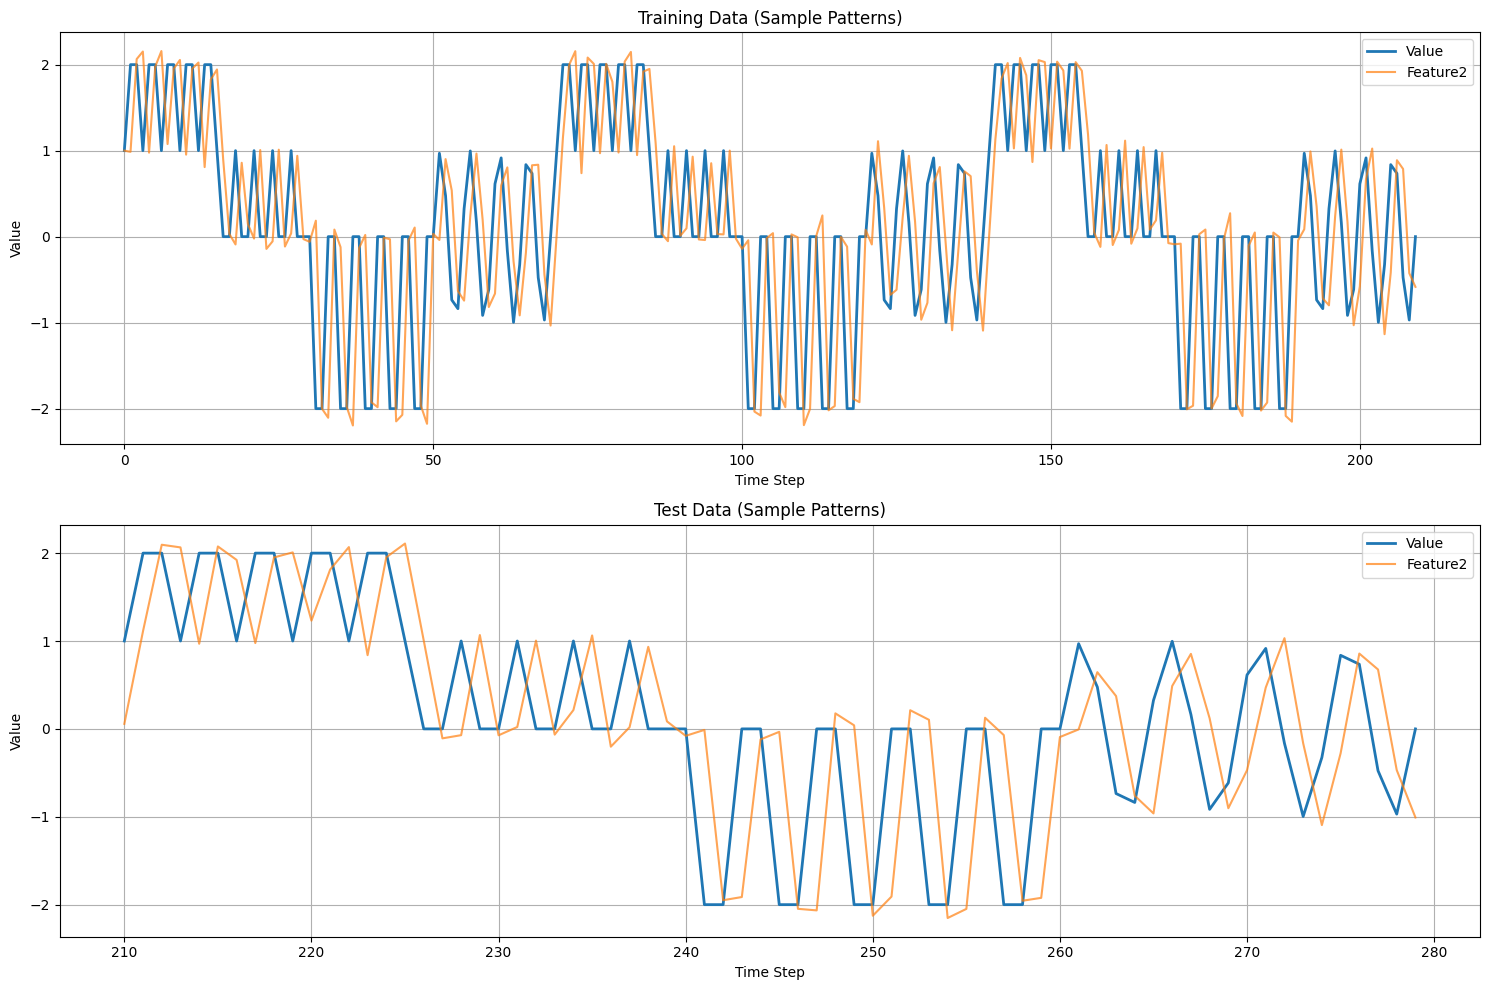

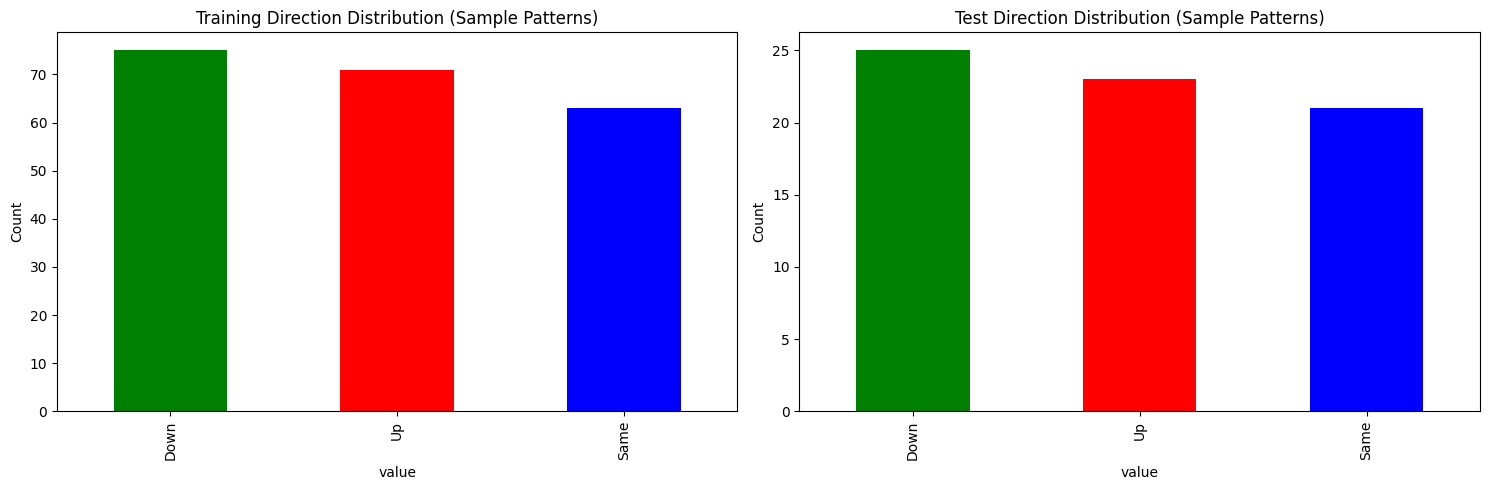


Random Walk Dataset Shapes:
Train: (750, 2)
Test: (250, 2)


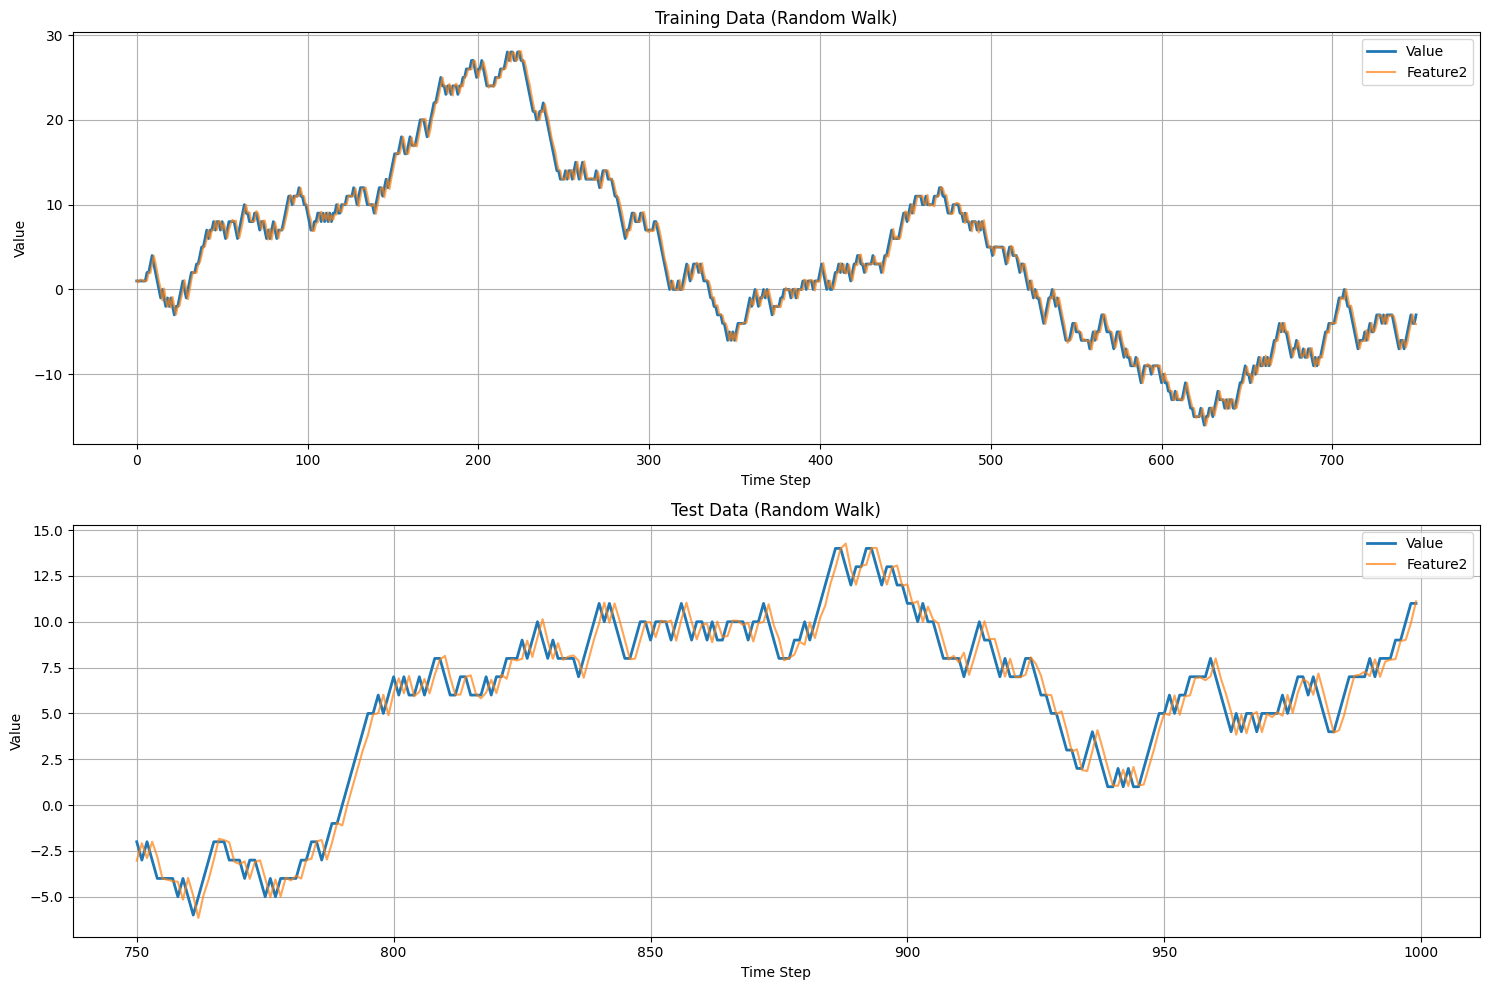

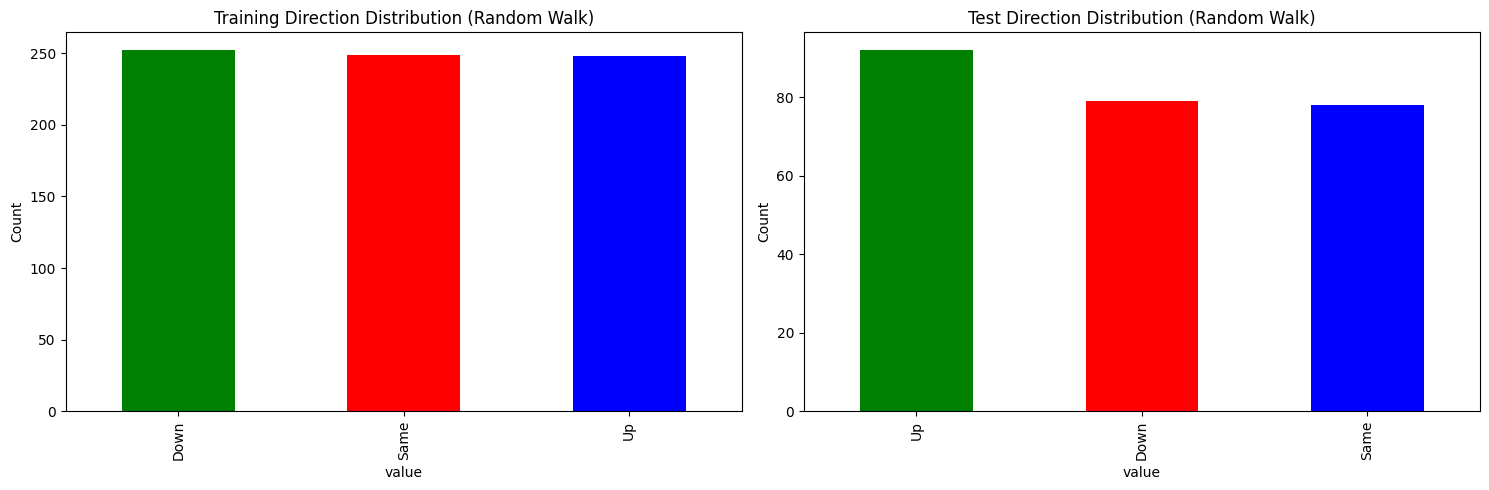

In [2]:
# Create simple pattern dataset
pattern_data = create_simple_timeseries(num_repeats=4, noise_factor=0.1, train_test_split=0.75)
print("Pattern Dataset Shapes:")
print(f"Train: {pattern_data.train_df.shape}")
print(f"Test: {pattern_data.test_df.shape}")

# Visualize pattern data
pattern_data.plot_series(save_path="pattern_data_plot.png")
pattern_data.plot_directions(save_path="pattern_directions_plot.png")

# Create random walk dataset
random_walk_data = create_random_walk(n_steps=1000, step_size=1.0, train_test_split=0.75)
print("\nRandom Walk Dataset Shapes:")
print(f"Train: {random_walk_data.train_df.shape}")
print(f"Test: {random_walk_data.test_df.shape}")

# Visualize random walk data
random_walk_data.plot_series(save_path="random_walk_plot.png")
random_walk_data.plot_directions(save_path="random_walk_directions_plot.png")


In [ ]:
# Using the pattern dataset for training
data_df = pattern_data.train_df.copy()

### 1.3 Setup RL Environment Parameters
Define the key parameters for our RL environment:

In [4]:
LOOKBACK = 7                        # Number of past time steps to consider
TARGET_COLUMN = 'value'             # Column for reward calculation and action
NORMALIZE_STATE = True              # Normalize state if True
NUM_FEATURES = data_df.shape[1]     # Number of features in the dataset
OUTPUT_SIZE = 3                     # Number of actions (Up, Down, Same)

### 1.4 Create Dataset and DataLoader
Set up the dataset and dataloader for training:

In [5]:
try:
    full_dataset = SequentialTimeSeriesDataset(
        data=data_df,
        lookback=LOOKBACK,
    )
    print(f"\nRL Dataset created. Num valid steps: {len(full_dataset)}")

    # Get the first dataset item
    first_ts_idx = full_dataset[0]
    print(f"First dataset item corresponds to time series index: {first_ts_idx}")

    # Create DataLoader
    dataloader = DataLoader(full_dataset, batch_size=len(full_dataset), shuffle=False, num_workers=0)
    print(f"DataLoader created. Batches: {len(dataloader)}")

except ValueError as e:
    print(f"\nError creating dataset: {e}")
    exit()


RL Dataset created. Num valid steps: 203
First dataset item corresponds to time series index: 7
DataLoader created. Batches: 1


### 1.5 Define and Initialize the Agent
Create the PolicyGradientAgent with our desired configuration:

In [6]:
# Agent configuration
hidden_layers_config = [100, 100, 10]           # Flexible hidden layers
learning_rate = 0.001                           # Initial learning rate
epsilon_start = 1.0                             # Initial exploration rate
epsilon_end = 0.01                              # Final exploration rate

num_training_epochs = 1000                      # Number of training epochs

# Create agent
agent = PolicyGradientAgent(
    full_data=data_df,
    target_column=TARGET_COLUMN, 
    input_features=NUM_FEATURES,
    lookback=LOOKBACK,      
    hidden_layers=hidden_layers_config, 
    output_size=OUTPUT_SIZE,
    learning_rate=learning_rate,
    normalize_state=NORMALIZE_STATE, 
    epsilon_start=epsilon_start, 
    epsilon_end=epsilon_end, 
    epsilon_decay_epochs_rate=0.5,
    num_training_epochs=num_training_epochs,
    # activation_fn=nn.ReLU(),            # Optional: specify activation function
    # eval_noise_factor=0.1,              # Optional: noise for evaluation
)

print("\nAgent Policy Network Summary:")
print(agent.network)


Agent Policy Network Summary:
Sequential(
  (0): Linear(in_features=14, out_features=100, bias=True)
  (1): Tanh()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): Tanh()
  (4): Linear(in_features=100, out_features=10, bias=True)
  (5): Tanh()
  (6): Linear(in_features=10, out_features=3, bias=True)
)


### 1.6 Train the Agent
Set up the PyTorch Lightning trainer and train the agent:

In [7]:
# Setup trainer
trainer = L.Trainer(
    max_epochs=num_training_epochs,
    accelerator='auto',
    devices='auto',
    log_every_n_steps=1,
    enable_checkpointing=True,
    logger=L.pytorch.loggers.CSVLogger("logs", name="single_models"),
    deterministic=True,
)

# Train the agent
print(f"\nStarting RL training...")
trainer.fit(agent, dataloader)
print("\nTraining finished.")

# Evaluate the trained model
trainer.validate(model=agent, dataloaders=dataloader)
print("\nEvaluation finished.")

# Save the model
model_dir = trainer.logger.log_dir 
trainer.save_checkpoint(os.path.join(model_dir, "policy_agent.ckpt"))
print(f"Trained model saved to: {os.path.join(model_dir, 'policy_agent.ckpt')}")

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Collins P. Ohagwu\anaconda3\envs\tests\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
c:\Users\Collins P. Ohagwu\anaconda3\envs\tests\Lib\site-packages\lightning\pytorch\trainer\connectors\dat


Starting RL training...
Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, v_num=1, train_reward=0.554, train_loss=-0.179, epsilon=0.010]  

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.90it/s, v_num=1, train_reward=0.554, train_loss=-0.179, epsilon=0.010]

c:\Users\Collins P. Ohagwu\anaconda3\envs\tests\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.




Training finished.
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     val_avg_reward         0.5643564462661743
   val_pass_percentage       78.21781921386719
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluation finished.
Trained model saved to: logs\single_models\version_1\policy_agent.ckpt


### 1.7 Plot Training Logs
Visualize the training progress:

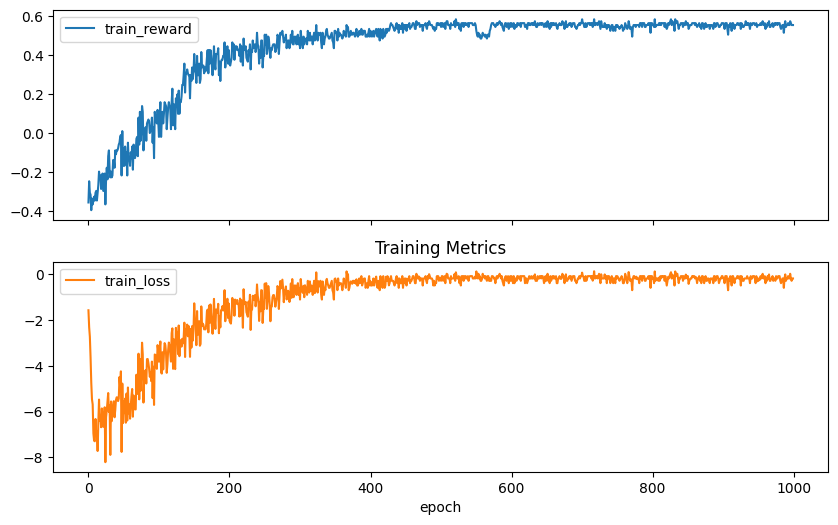

In [8]:
# Read the training metrics from the logs directory for visualization
logs = pd.read_csv(os.path.join(model_dir, "metrics.csv"))
logs.set_index('epoch', inplace=True)
logs[['train_reward', 'train_loss']].plot(subplots=True, figsize=(10, 6))
plt.title("Training Metrics")
plt.savefig(os.path.join(model_dir, "training_metrics.png"))
plt.show()

## Part 2: Testing the Agent

With our agent now trained, the next crucial step is to evaluate its performance on the test dataset. This process closely mirrors how you'd deploy and assess your model in a real-world scenario.
### 2.1 Import Additional Libraries for Testing

In [ ]:
import torch.nn.functional as F
from timeseries_agent.utils import get_state_tensor, calculate_reward

### 2.2 Create Test Data
Load your test dataset. This unseen, recent data is crucial for accurately gauging your agent's generalization capabilities and identifying areas for improvement. We'll load the test set directly from our data module.

In [10]:
test_df = pattern_data.test_df.copy()

### 2.3 Load Trained Agent
Load the agent we trained earlier:

In [11]:
model_dir = "logs/single_models/version_1"                  # Change the version number as needed
model_path = os.path.join(model_dir, "policy_agent.ckpt")
hparams_path = os.path.join(model_dir, "hparams.yaml")

# Load agent
agent = PolicyGradientAgent.load_from_checkpoint(model_path, hparams_file=hparams_path, full_data=test_df)
agent.eval()
print(f"Loaded trained model from: {model_path}")

# Get parameters from agent
LOOKBACK = agent.lookback
TARGET_COLUMN = agent.hparams.target_column
NORMALIZE_STATE = agent.normalize_state

# Initialize with LOOKBACK data points
current_data = test_df.iloc[:LOOKBACK].copy()
print("\nInitial Test DataFrame (first LOOKBACK period):")
print(current_data)

Loaded trained model from: logs/single_models/version_1\policy_agent.ckpt

Initial Test DataFrame (first LOOKBACK period):
     value  feature2
210    1.0  0.057089
211    2.0  1.113557
212    2.0  2.095400
213    1.0  2.065139
214    2.0  0.968473
215    2.0  2.075897
216    1.0  1.922717


### 2.4 Run Test Loop
Evaluate the agent on the test dataset while collecting predicted and true actions:

In [12]:
print("\nStarting test loop with sudo live data updates...")
total_test_reward = 0
test_pass_count = 0
num_test_steps = 0
predicted_actions = []
true_actions = []

for i in range(LOOKBACK, len(test_df)):
    num_test_steps += 1
    
    # Get state
    state = get_state_tensor(current_data.values, LOOKBACK, LOOKBACK, NORMALIZE_STATE)
    state = state.to(agent.device)

    # Predict action
    with torch.no_grad():
        logits = agent(state)
        probabilities = F.softmax(logits, dim=1)
        action = torch.argmax(probabilities).item()

    # Calculate reward
    current_val = test_df.iloc[LOOKBACK - 1 + (i - LOOKBACK), test_df.columns.get_loc(TARGET_COLUMN)]
    next_val = test_df.iloc[LOOKBACK + (i - LOOKBACK), test_df.columns.get_loc(TARGET_COLUMN)]
    reward = calculate_reward(current_val, next_val, action)
    total_test_reward += reward
    if reward == 1:
        test_pass_count += 1

    # Store actions
    predicted_actions.append(action)
    if next_val > current_val:
        true_action = 0
    elif next_val < current_val:
        true_action = 1
    else:
        true_action = 2
    true_actions.append(true_action)
    
    print(f"\n--- Step {i - LOOKBACK + 1} ---")
    print(f"Time Index: {i}, Action: {action}, Reward: {reward}")

    # Update current data
    current_data = pd.concat([current_data, test_df.iloc[[i]]], ignore_index=True)
    current_data = current_data.iloc[1:].reset_index(drop=True)

# Calculate final metrics
avg_test_reward = total_test_reward / num_test_steps if num_test_steps > 0 else 0
test_pass_percentage = test_pass_count / num_test_steps * 100 if num_test_steps > 0 else 0

print("\n--- Testing Finished ---")
print(f"Total Test Steps: {num_test_steps}")
print(f"Average Test Reward: {avg_test_reward:.4f}")
print(f"Test Pass Percentage (Accuracy): {test_pass_percentage:.2f}%")


Starting test loop with sudo live data updates...

--- Step 1 ---
Time Index: 7, Action: 0, Reward: 1

--- Step 2 ---
Time Index: 8, Action: 2, Reward: 1

--- Step 3 ---
Time Index: 9, Action: 1, Reward: 1

--- Step 4 ---
Time Index: 10, Action: 0, Reward: 1

--- Step 5 ---
Time Index: 11, Action: 2, Reward: 1

--- Step 6 ---
Time Index: 12, Action: 1, Reward: 1

--- Step 7 ---
Time Index: 13, Action: 0, Reward: 1

--- Step 8 ---
Time Index: 14, Action: 2, Reward: 1

--- Step 9 ---
Time Index: 15, Action: 1, Reward: 1

--- Step 10 ---
Time Index: 16, Action: 0, Reward: -1

--- Step 11 ---
Time Index: 17, Action: 0, Reward: -1

--- Step 12 ---
Time Index: 18, Action: 0, Reward: 1

--- Step 13 ---
Time Index: 19, Action: 0, Reward: -1

--- Step 14 ---
Time Index: 20, Action: 2, Reward: 1

--- Step 15 ---
Time Index: 21, Action: 0, Reward: 1

--- Step 16 ---
Time Index: 22, Action: 1, Reward: 1

--- Step 17 ---
Time Index: 23, Action: 1, Reward: -1

--- Step 18 ---
Time Index: 24, Action

### 2.5 Visualize Results
Let's create some visualizations to analyze the agent's performance. First, we'll import some handy functions from the utils module.

In [13]:
from timeseries_agent.utils.visualization import (
    plot_signal_line_chart,
    plot_confusion_matrix,
    create_animated_prediction_plot
)

In [14]:
# Define action labels
ACTION_LABELS = {0: 'Up', 1: 'Down', 2: 'Same'}

# Prepare DataFrame for visualization
pred_data = test_df.iloc[LOOKBACK-1:-1].copy()
pred_data.index.name = 'Time Step'

# One-hot encode predicted actions for visualization
for action, label in ACTION_LABELS.items():
    pred_data[label] = [1 if x == action else 0 for x in predicted_actions]

# Add predicted and true actions to the DataFrame
pred_data['predicted_action'] = predicted_actions
pred_data['true_action'] = true_actions
pred_data.head()

,value,feature2,Up,Down,Same,predicted_action,true_action
Time Step,,,,,,,
216,1.0,1.922717,1,0,0,0,0
217,2.0,0.976318,0,0,1,2,2
218,2.0,1.951464,0,1,0,1,1
219,1.0,2.008187,1,0,0,0,0
220,2.0,1.231466,0,0,1,2,2


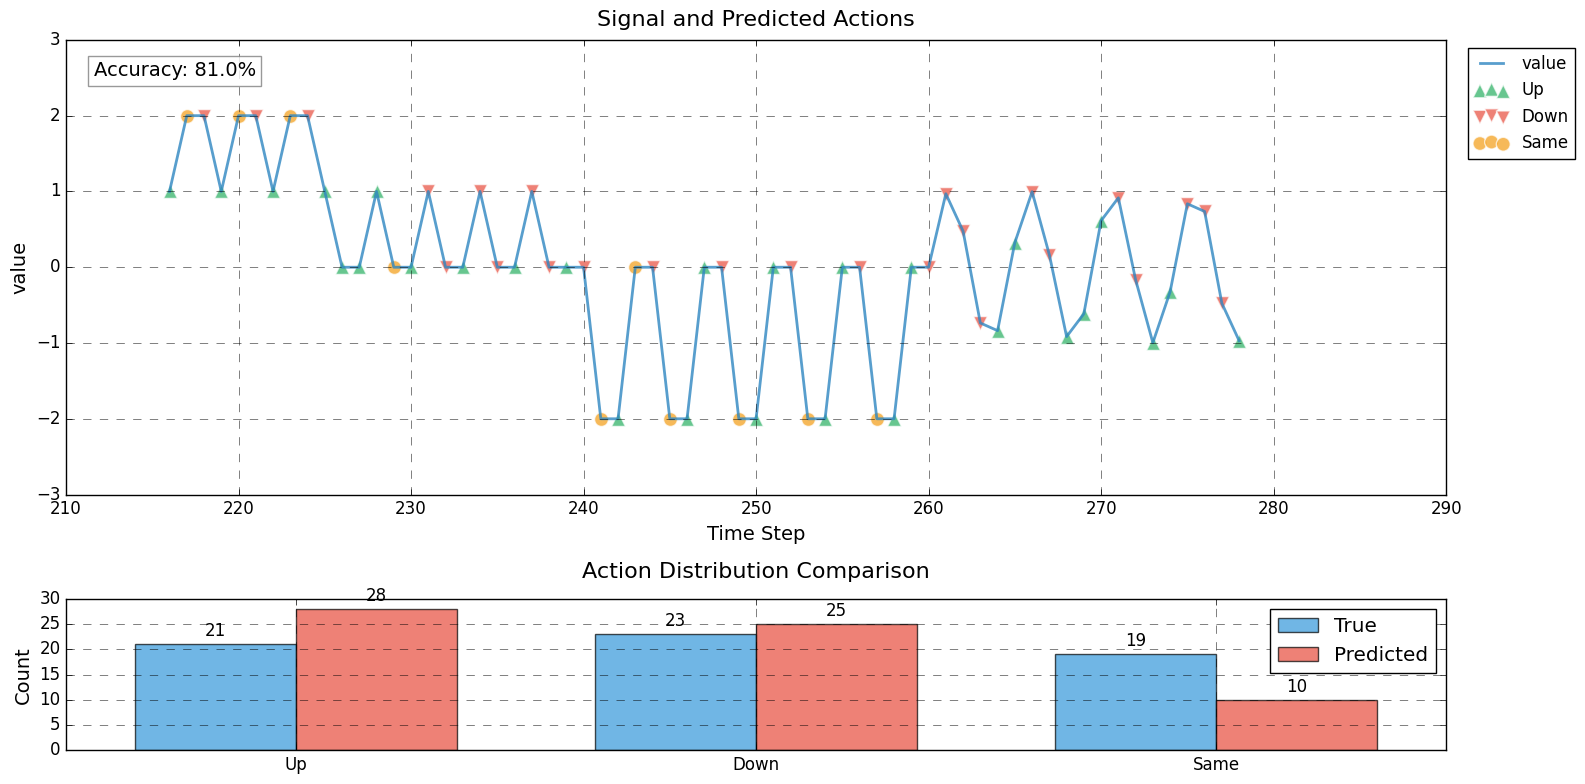

In [15]:
# 1. Signal line chart with predictions
plot_signal_line_chart(
    df=pred_data,
    target_column='value',  
    action_labels=ACTION_LABELS,
    save_path=os.path.join(model_dir, 'predictions_analysis.png')
)

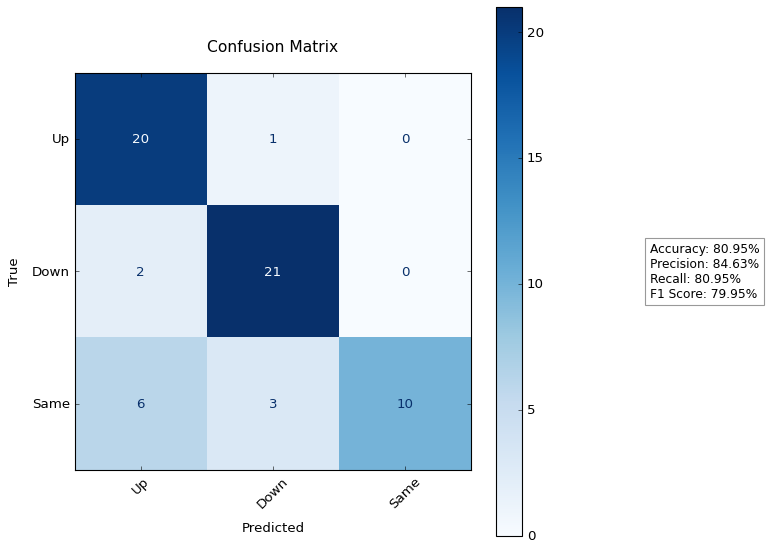

In [16]:
# 2. Confusion matrix
plot_confusion_matrix(
    true_actions=true_actions,
    predicted_actions=predicted_actions,
    action_labels=ACTION_LABELS,
    save_path=os.path.join(model_dir, 'confusion_matrix.png')
)

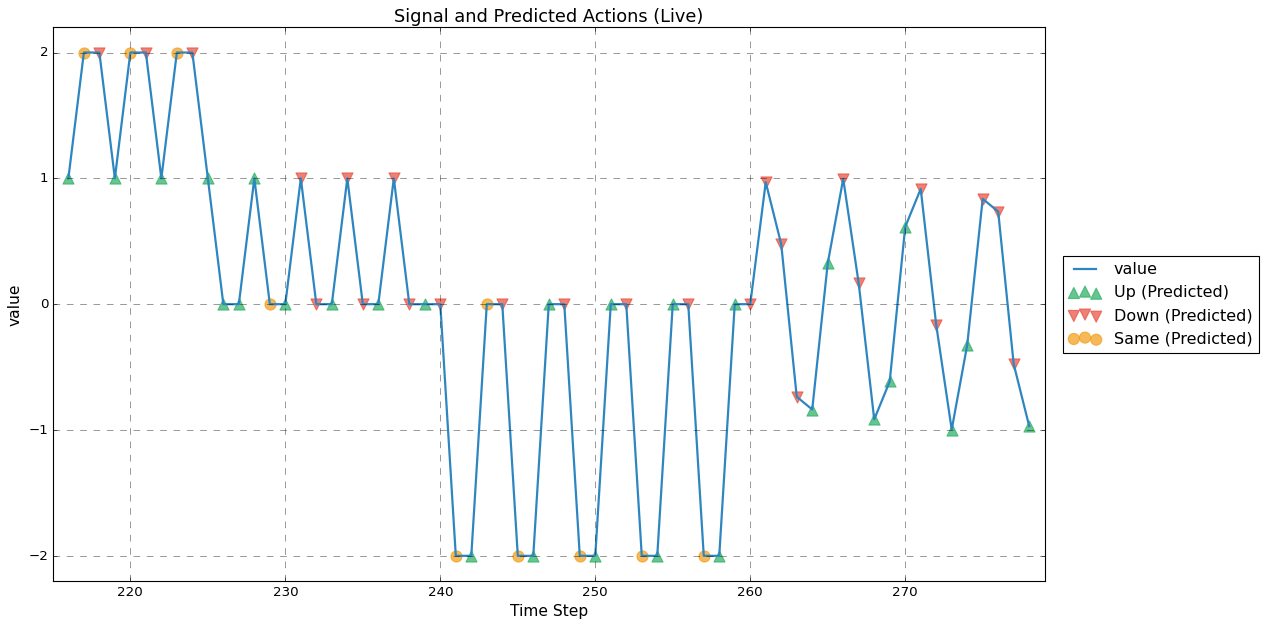

In [17]:
create_animated_prediction_plot(
    df=pred_data,
    target_column='value',  
    action_labels=ACTION_LABELS,
    save_path=os.path.join(model_dir, 'predictions_animation.gif')
)